# LinkedIn Profile Classification - TF–IDF + logistic regression classifier

### Critical Data Discovery

**Other Under-prediction Issue:** In the department test set, “Other” is the dominant class (344/623) but the classifier achieves precision/recall/F1 = 0.00, that is, it almost never predicts “Other” and instead misroutes these cases into specific departments, causing the very low accuracy (0.218). Adding a confidence threshold τ and mapping low-confidence predictions to the fallback label “Other” fixes this failure mode and improves test performance.

### Approach

Confidence-aware text classification (TF–IDF + Logistic Regression):
1. **TF–IDF Representation** - Convert titles into weighted term features (bag-of-words with IDF)
2. **Linear Classifier (LR)** - Train two supervised models: Department and Seniority
3. **Confidence Thresholding (τ) + Fallback** - If max class probability < τ, assign an intelligent fallback\
    3.1. *Seniority Fallback* -  “Professional”: unseen label in training\
    3.2. *Department Fallback* -  “Other”: catch-all class with weak signals

---
## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_recall_fscore_support
import re
from difflib import SequenceMatcher
import warnings
from functools import lru_cache
import time

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print('Libraries loaded successfully!')

Libraries loaded successfully!


In [2]:
# Load data
df_seniority = pd.read_csv('seniority-v2.csv')
df_department = pd.read_csv('department-v2.csv')

with open('testdata.txt', 'r', encoding='utf-8') as f:
    test_cvs = json.load(f)

print('=' * 60)
print('DATA LOADING SUMMARY')
print('=' * 60)
print(f'Seniority labels (training): {len(df_seniority):,} entries')
print(f'Department labels (training): {len(df_department):,} entries')
print(f'Test CVs: {len(test_cvs)} profiles')
print(f'\nDepartment categories: {sorted(df_department["label"].unique())}')
print(f'\nSeniority categories (training): {sorted(df_seniority["label"].unique())}')

DATA LOADING SUMMARY
Seniority labels (training): 9,428 entries
Department labels (training): 10,145 entries
Test CVs: 609 profiles

Department categories: ['Administrative', 'Business Development', 'Consulting', 'Customer Support', 'Human Resources', 'Information Technology', 'Marketing', 'Other', 'Project Management', 'Purchasing', 'Sales']

Seniority categories (training): ['Director', 'Junior', 'Lead', 'Management', 'Senior']


In [3]:
def extract_active_jobs(cvs):
    """Extract only ACTIVE (current) job positions from CVs."""
    active_jobs = []
    for cv in cvs:
        for job in cv:
            if job.get('status') == 'ACTIVE':
                active_jobs.append(job)
    return active_jobs

test_active_jobs = extract_active_jobs(test_cvs)
df_test = pd.DataFrame(test_active_jobs)

print(f'Active jobs extracted: {len(df_test)}')
print(f'\nSeniority in TEST: {sorted(df_test["seniority"].unique())}')
print(f'Seniority in TRAIN: {sorted(df_seniority["label"].unique())}')
print(f'\n⚠️ "Professional" is in TEST but NOT in TRAINING!')

Active jobs extracted: 623

Seniority in TEST: ['Director', 'Junior', 'Lead', 'Management', 'Professional', 'Senior']
Seniority in TRAIN: ['Director', 'Junior', 'Lead', 'Management', 'Senior']

⚠️ "Professional" is in TEST but NOT in TRAINING!


---
## 2. Data Preprocessing

In [4]:
@lru_cache(maxsize=20000)
def preprocess_text(text):
    """Normalize text for matching."""
    if pd.isna(text) or text is None:
        return ''
    text = str(text).lower().strip()
    text = re.sub(r'[^a-zäöüßàâçéèêëîïôûùüÿñæœ\s]', ' ', text)
    return ' '.join(text.split())

# Test
for t in ['Senior Engineer', 'Geschäftsführer', 'Chef de projet']:
    print(f'{t} -> {preprocess_text(t)}')

Senior Engineer -> senior engineer
Geschäftsführer -> geschäftsführer
Chef de projet -> chef de projet


---
## 3. Approaches

### 3.1 TF–IDF + logistic regression classifier

In [5]:
# Build training sets of department and seniority, and split them into validation sets
X_dept = df_department["text"].astype(str).apply(preprocess_text).values
y_dept = df_department["label"].values

X_sen = df_seniority["text"].astype(str).apply(preprocess_text).values
y_sen = df_seniority["label"].values

X_dept_tr, X_dept_val, y_dept_tr, y_dept_val = train_test_split(
    X_dept, y_dept, test_size=0.2, random_state=123, stratify=y_dept
)
X_sen_tr, X_sen_val, y_sen_tr, y_sen_val = train_test_split(
    X_sen, y_sen, test_size=0.2, random_state=123, stratify=y_sen
)

# Use pipline class
dept_clf = Pipeline([
    ("vect", CountVectorizer(ngram_range=(1, 1), min_df=2)),
    ("tfidf", TfidfTransformer()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

sen_clf = Pipeline([
    ("vect", CountVectorizer(ngram_range=(1, 1), min_df=2)),
    ("tfidf", TfidfTransformer()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

dept_clf.fit(X_dept_tr, y_dept_tr)
sen_clf.fit(X_sen_tr, y_sen_tr)

dept_val_pred = dept_clf.predict(X_dept_val)
sen_val_pred  = sen_clf.predict(X_sen_val)

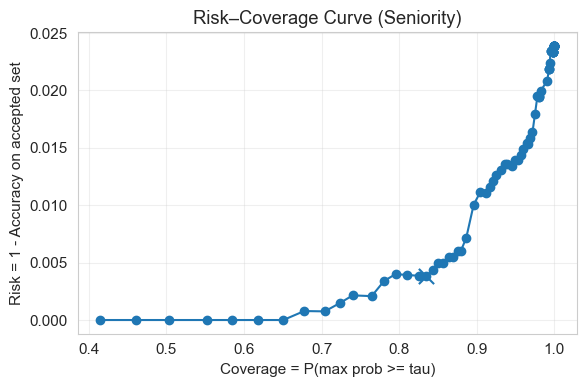

Chosen sen_tau (elbow): 0.7899999999999999
Coverage at sen_tau: 0.8345705196182397
Risk at sen_tau: 0.003811944091486663
At tau=0.79, 16.54% of validation samples are *rejected* (max prob < tau).
Because 'Professional' is not in y_val, these rejected cases are not evaluated as a true class, 'Professional' is only a fallback label used for deployment.


In [29]:
# Find reasonable thresholded of fallback to "Professional" in seniority
def predict_with_threshold(model, X, tau, fallback_label):
    proba = model.predict_proba(X)                              
    pred = model.classes_[np.argmax(proba, axis=1)]            
    max_proba = np.max(proba, axis=1)                           
    pred = np.where(max_proba < tau, fallback_label, pred)      
    return pred, max_proba

# Select tau by the elbow (knee) point on the risk–coverage curve
def choose_tau_elbow(model, X_val, y_val, tau_grid=None):
    if tau_grid is None:
        tau_grid = np.linspace(0.05, 0.95, 91)

    proba_val = model.predict_proba(X_val)
    pred_val = model.classes_[np.argmax(proba_val, axis=1)]
    maxp_val = np.max(proba_val, axis=1)

    coverages = []
    risks = []

    for tau in tau_grid:
        accepted = (maxp_val >= tau)
        cov = float(np.mean(accepted))

        if accepted.sum() == 0:
            risk = 1.0
        else:
            acc = float(np.mean(pred_val[accepted] == y_val[accepted]))
            risk = 1.0 - acc

        coverages.append(cov)
        risks.append(risk)

    coverages = np.array(coverages)
    risks = np.array(risks)

    # Elbow via maximum distance to the line connecting endpoints
    x, y = coverages, risks
    x0, y0 = x[0], y[0]
    x1, y1 = x[-1], y[-1]
    baseline = np.sqrt((x1 - x0) ** 2 + (y1 - y0) ** 2) + 1e-12
    dist = np.abs((y1 - y0) * x - (x1 - x0) * y + x1 * y0 - y1 * x0) / baseline

    best_idx = int(np.argmax(dist))
    best_tau = float(tau_grid[best_idx])

    info = {
        "tau": best_tau,
        "coverage": float(coverages[best_idx]),
        "risk": float(risks[best_idx]),
        "tau_grid": tau_grid,
        "coverages": coverages,
        "risks": risks,
    }
    return info

# Run elbow selection on seniority validation split and plot the risk-coverage curve
tau_info = choose_tau_elbow(sen_clf, X_sen_val, y_sen_val)
sen_tau = tau_info["tau"]

coverages = np.array(tau_info["coverages"])
risks = np.array(tau_info["risks"])
tau_grid = np.array(tau_info["tau_grid"])

best_tau = tau_info["tau"]
best_cov = tau_info["coverage"]
best_risk = tau_info["risk"]
rejected_rate = 1 - best_cov

plt.figure(figsize=(6,4))
plt.plot(coverages, risks, marker="o", linestyle="-")
plt.scatter([best_cov], [best_risk], s=120, marker="x")
plt.title("Risk–Coverage Curve (Seniority)")
plt.xlabel("Coverage = P(max prob >= tau)")
plt.ylabel("Risk = 1 - Accuracy on accepted set")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("Figure R-C.png", dpi=300, bbox_inches="tight")
plt.show()

print("Chosen sen_tau (elbow):", sen_tau)
print("Coverage at sen_tau:", tau_info["coverage"])
print("Risk at sen_tau:", tau_info["risk"])
print(f"At tau={tau_info['tau']:.2f}, {rejected_rate:.2%} of validation samples are *rejected* (max prob < tau).")
print("Because 'Professional' is not in y_val, these rejected cases are not evaluated as a true class, 'Professional' is only a fallback label used for deployment.")

In [7]:
## Do a sanity check with the accuracy of department and seniority test set
X_test = df_test["position"].astype(str).apply(preprocess_text).values
dept_pred = dept_clf.predict(X_test)
dept_acc = accuracy_score(df_test["department"], dept_pred)

print("=== Department sanity check (TEST) ===")
print("Accuracy:", dept_acc)
print("\nClassification report:")
print(classification_report(df_test["department"], dept_pred, digits=4))

df_test["pred_sen_thr"], df_test["sen_maxp"] = predict_with_threshold(
    sen_clf, X_test, tau=sen_tau, fallback_label="Professional"
)

print("\n=== Seniority sanity check (TEST, thresholded) ===")
print("Accuracy:", accuracy_score(df_test["seniority"], df_test["pred_sen_thr"]))
print("Fallback rate on TEST:", float(np.mean(df_test["sen_maxp"] < sen_tau)))
print("Predicted 'Professional' rate:", float(np.mean(df_test["pred_sen_thr"] == "Professional")))
print("True 'Professional' rate     :", float(np.mean(df_test["seniority"].values == "Professional")))
print("\nClassification report:")
print(classification_report(df_test["seniority"], df_test["pred_sen_thr"], digits=4))

=== Department sanity check (TEST) ===
Accuracy: 0.21829855537720708

Classification report:
                        precision    recall  f1-score   support

        Administrative     0.1667    0.0714    0.1000        14
  Business Development     0.3529    0.3000    0.3243        20
            Consulting     0.7727    0.4359    0.5574        39
      Customer Support     1.0000    0.3333    0.5000         6
       Human Resources     0.7273    0.5000    0.5926        16
Information Technology     0.2018    0.3710    0.2614        62
             Marketing     0.3571    0.4545    0.4000        22
                 Other     0.0000    0.0000    0.0000       344
    Project Management     0.1067    0.6923    0.1849        39
            Purchasing     0.7273    0.5333    0.6154        15
                 Sales     0.2179    0.7391    0.3366        46

              accuracy                         0.2183       623
             macro avg     0.4209    0.4028    0.3521       623
         

In [8]:
# Due to the low accuracy of department prediction, pick tau on department validation using elbow
dept_tau_info = choose_tau_elbow(dept_clf, X_dept_val, y_dept_val)
dept_tau = dept_tau_info["tau"]

print("Chosen dept_tau (elbow):", dept_tau)
print("Coverage at dept_tau:", dept_tau_info["coverage"])
print("Risk at dept_tau:", dept_tau_info["risk"])

# Apply on test set with fallback to "Other"
df_test["pred_dept_thr"], df_test["dept_max_proba"] = predict_with_threshold(
    dept_clf, X_test, dept_tau, fallback_label="Other"
)

# Do sanity check again
print("\nDept test acc (thresholded):",
      accuracy_score(df_test["department"], df_test["pred_dept_thr"]))
print("\nClassification report (dept, thresholded):")
print(classification_report(df_test["department"], df_test["pred_dept_thr"], digits=4))
print("\nFallback rate on TEST (dept):", float(np.mean(df_test["dept_max_proba"] < dept_tau)))

Chosen dept_tau (elbow): 0.72
Coverage at dept_tau: 0.7550517496303598
Risk at dept_tau: 0.02284595300261094

Dept test acc (thresholded): 0.680577849117175

Classification report (dept, thresholded):
                        precision    recall  f1-score   support

        Administrative     1.0000    0.0714    0.1333        14
  Business Development     0.4167    0.2500    0.3125        20
            Consulting     0.9333    0.3590    0.5185        39
      Customer Support     0.0000    0.0000    0.0000         6
       Human Resources     0.7778    0.4375    0.5600        16
Information Technology     1.0000    0.1129    0.2029        62
             Marketing     0.6667    0.2727    0.3871        22
                 Other     0.6462    0.9767    0.7778       344
    Project Management     0.9048    0.4872    0.6333        39
            Purchasing     1.0000    0.4000    0.5714        15
                 Sales     1.0000    0.5000    0.6667        46

              accuracy       

---
## 4 Model Evaluation

### 4.1 TF–IDF + logistic regression classifier

In [9]:
print("Generating predictions (TF–IDF + Logistic Regression)...")
start = time.time()

X_test_titles = df_test["position"].astype(str).fillna("")
df_test["pred_dept_thr"], df_test["dept_max_proba"] = predict_with_threshold(
    dept_clf, X_test_titles, dept_tau, fallback_label="Other"
)

df_test["pred_sen_thr"], df_test["sen_max_proba"] = predict_with_threshold(
    sen_clf, X_test_titles, sen_tau, fallback_label="Professional"
)

elapsed = time.time() - start
print(f"✓ Done in {elapsed:.2f}s ({len(df_test)/elapsed:.0f}/sec)")

Generating predictions (TF–IDF + Logistic Regression)...
✓ Done in 0.01s (42200/sec)


In [10]:
def summarize_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    return acc, f1_macro, f1_weighted

dept_acc, dept_f1_macro, dept_f1_weighted = summarize_metrics(df_test["department"], df_test["pred_dept_thr"])
sen_acc,  sen_f1_macro,  sen_f1_weighted  = summarize_metrics(df_test["seniority"],  df_test["pred_sen_thr"])

print("\n" + "="*65)
print("        TF–IDF + LOGISTIC REGRESSION RESULTS")
print("="*65)
print(f"\n{'Metric':<30}{'Department':>15}{'Seniority':>15}")
print("-"*65)
print(f"{'Accuracy':<30}{dept_acc*100:>14.2f}%{sen_acc*100:>14.2f}%")
print(f"{'F1 (Macro)':<30}{dept_f1_macro:>15.3f}{sen_f1_macro:>15.3f}")
print(f"{'F1 (Weighted)':<30}{dept_f1_weighted:>15.3f}{sen_f1_weighted:>15.3f}")
print("="*65)


        TF–IDF + LOGISTIC REGRESSION RESULTS

Metric                             Department      Seniority
-----------------------------------------------------------------
Accuracy                               68.06%         57.78%
F1 (Macro)                              0.433          0.515
F1 (Weighted)                           0.626          0.590


In [11]:
print('\nDEPARTMENT CLASSIFICATION REPORT')
print('=' * 70)
print(classification_report(df_test['department'], df_test['pred_dept_thr'], zero_division=0))


DEPARTMENT CLASSIFICATION REPORT
                        precision    recall  f1-score   support

        Administrative       1.00      0.07      0.13        14
  Business Development       0.42      0.25      0.31        20
            Consulting       0.93      0.36      0.52        39
      Customer Support       0.00      0.00      0.00         6
       Human Resources       0.78      0.44      0.56        16
Information Technology       1.00      0.11      0.20        62
             Marketing       0.67      0.27      0.39        22
                 Other       0.65      0.98      0.78       344
    Project Management       0.90      0.49      0.63        39
            Purchasing       1.00      0.40      0.57        15
                 Sales       1.00      0.50      0.67        46

              accuracy                           0.68       623
             macro avg       0.76      0.35      0.43       623
          weighted avg       0.75      0.68      0.63       623



In [12]:
print('\nSENIORITY CLASSIFICATION REPORT')
print('=' * 70)
print(classification_report(df_test['seniority'], df_test['pred_sen_thr'], zero_division=0))


SENIORITY CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Director       0.55      0.71      0.62        34
      Junior       0.30      0.25      0.27        12
        Lead       0.98      0.38      0.54       125
  Management       0.97      0.52      0.67       192
Professional       0.50      0.73      0.60       216
      Senior       0.28      0.66      0.39        44

    accuracy                           0.58       623
   macro avg       0.60      0.54      0.52       623
weighted avg       0.73      0.58      0.59       623



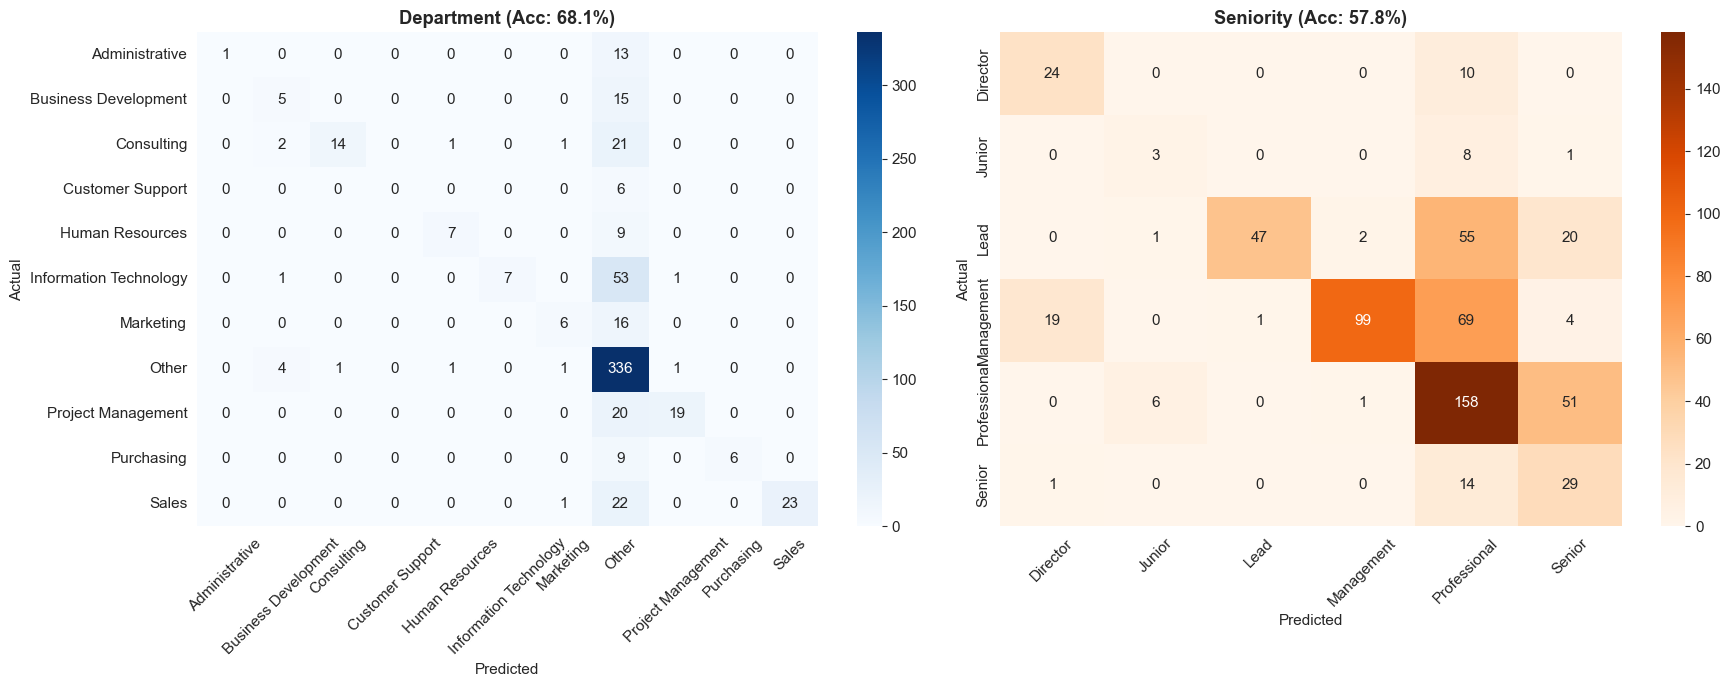

In [13]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

dept_labels = sorted(df_test['department'].unique())
cm_dept = confusion_matrix(df_test['department'], df_test['pred_dept_thr'], labels=dept_labels)
sns.heatmap(cm_dept, annot=True, fmt='d', cmap='Blues',
            xticklabels=dept_labels, yticklabels=dept_labels, ax=axes[0])
axes[0].set_title(f'Department (Acc: {dept_acc*100:.1f}%)', fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].tick_params(axis='x', rotation=45)

sen_labels = sorted(df_test['seniority'].unique())
cm_sen = confusion_matrix(df_test['seniority'], df_test['pred_sen_thr'], labels=sen_labels)
sns.heatmap(cm_sen, annot=True, fmt='d', cmap='Oranges',
            xticklabels=sen_labels, yticklabels=sen_labels, ax=axes[1])
axes[1].set_title(f'Seniority (Acc: {sen_acc*100:.1f}%)', fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

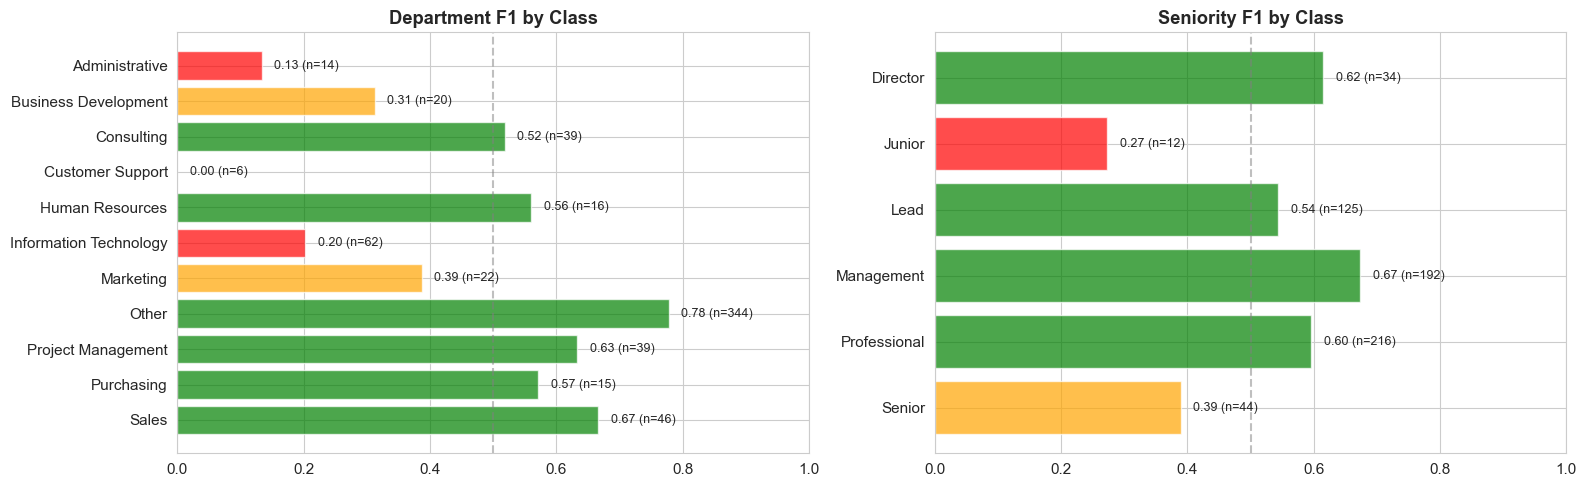

In [14]:
# Per-class F1
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

d_p, d_r, d_f1, d_s = precision_recall_fscore_support(df_test['department'], df_test['pred_dept_thr'], 
                                                       labels=dept_labels, zero_division=0)
colors = ['green' if f > 0.5 else 'orange' if f > 0.3 else 'red' for f in d_f1]
axes[0].barh(dept_labels, d_f1, color=colors, alpha=0.7)
axes[0].set_title('Department F1 by Class', fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].axvline(0.5, color='gray', linestyle='--', alpha=0.5)
for i, (f, s) in enumerate(zip(d_f1, d_s)):
    axes[0].text(f + 0.02, i, f'{f:.2f} (n={s})', va='center', fontsize=9)
axes[0].invert_yaxis()

s_p, s_r, s_f1, s_s = precision_recall_fscore_support(df_test['seniority'], df_test['pred_sen_thr'], 
                                                       labels=sen_labels, zero_division=0)
colors = ['green' if f > 0.5 else 'orange' if f > 0.3 else 'red' for f in s_f1]
axes[1].barh(sen_labels, s_f1, color=colors, alpha=0.7)
axes[1].set_title('Seniority F1 by Class', fontweight='bold')
axes[1].set_xlim(0, 1)
axes[1].axvline(0.5, color='gray', linestyle='--', alpha=0.5)
for i, (f, s) in enumerate(zip(s_f1, s_s)):
    axes[1].text(f + 0.02, i, f'{f:.2f} (n={s})', va='center', fontsize=9)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

---
## 5 Error analysis

### 5.1 TF–IDF + logistic regression classifier

In [15]:
df_test['dept_ok'] = df_test['department'] == df_test['pred_dept_thr']
df_test['sen_ok'] = df_test['seniority'] == df_test['pred_sen_thr']

print('Error Summary:')
print('=' * 55)
print(f'Department errors: {(~df_test["dept_ok"]).sum()} ({(~df_test["dept_ok"]).mean()*100:.1f}%)')
print(f'Seniority errors: {(~df_test["sen_ok"]).sum()} ({(~df_test["sen_ok"]).mean()*100:.1f}%)')
print(f'Both correct: {(df_test["dept_ok"] & df_test["sen_ok"]).sum()}')

Error Summary:
Department errors: 199 (31.9%)
Seniority errors: 263 (42.2%)
Both correct: 258


In [16]:
# Top error patterns
dept_err = df_test[~df_test['dept_ok']]
patterns = dept_err.groupby(['department', 'pred_dept_thr']).size().reset_index(name='n')
patterns = patterns.sort_values('n', ascending=False).head(10)

print('\nTop Department Error Patterns:')
print('=' * 60)
print(f'{"Actual":<22} {"Predicted":<22} {"Count":>10}')
print('-' * 60)
for _, r in patterns.iterrows():
    print(f'{r["department"]:<22} {r["pred_dept_thr"]:<22} {r["n"]:>10}')


Top Department Error Patterns:
Actual                 Predicted                   Count
------------------------------------------------------------
Information Technology Other                          53
Sales                  Other                          22
Consulting             Other                          21
Project Management     Other                          20
Marketing              Other                          16
Business Development   Other                          15
Administrative         Other                          13
Human Resources        Other                           9
Purchasing             Other                           9
Customer Support       Other                           6


In [17]:
sen_err = df_test[~df_test['sen_ok']]
patterns = sen_err.groupby(['seniority', 'pred_sen_thr']).size().reset_index(name='n')
patterns = patterns.sort_values('n', ascending=False).head(10)

print('\nTop Seniority Error Patterns:')
print('=' * 55)
print(f'{"Actual":<18} {"Predicted":<18} {"Count":>10}')
print('-' * 55)
for _, r in patterns.iterrows():
    print(f'{r["seniority"]:<18} {r["pred_sen_thr"]:<18} {r["n"]:>10}')


Top Seniority Error Patterns:
Actual             Predicted               Count
-------------------------------------------------------
Management         Professional               69
Lead               Professional               55
Professional       Senior                     51
Lead               Senior                     20
Management         Director                   19
Senior             Professional               14
Director           Professional               10
Junior             Professional                8
Professional       Junior                      6
Management         Senior                      4


In [18]:
# Sample errors
print('\nSample Misclassified Titles:')
print('=' * 80)
for _, p in patterns.head(3).iterrows():
    samples = sen_err[(sen_err['seniority']==p['seniority']) & 
                      (sen_err['pred_sen_thr']==p['pred_sen_thr'])]['position'].head(3)
    print(f'\n{p["seniority"]} -> {p["pred_sen_thr"]} (n={p["n"]}):')
    for s in samples:
        print(f'  • {str(s)[:65]}')


Sample Misclassified Titles:

Management -> Professional (n=69):
  • Prokurist
  • CFO
  • Prokuristin

Lead -> Professional (n=55):
  • Gerente comercial
  • APL-ansvarig, samordning
  • Lab-Supervisor

Professional -> Senior (n=51):
  • Purchasing Manager
  • Physician Assistant
  • Product Manager


---
## 6. Results Summary

In [21]:
# Save results
cols = ['position', 'organization', 'department', 'pred_dept_thr', 'seniority', 'pred_sen_thr', 'dept_ok', 'sen_ok']
df_test[cols].to_csv('predictions_rule_based.csv', index=False)
print('✓ Saved predictions to predictions_rule_based.csv')

✓ Saved predictions to predictions_rule_based.csv


In [28]:
print('''
╔══════════════════════════════════════════════════════════════════════════════════╗
║              TF–IDF+Logistic Regression BASELINE - FINAL SUMMARY                 ║
╚══════════════════════════════════════════════════════════════════════════════════╝
''')
print(f'''
PERFORMANCE
{'─' * 50}
Department:  Accuracy={dept_acc*100:.1f}%, F1(macro)={dept_f1_macro:.3f}
Seniority:   Accuracy={sen_acc*100:.1f}%, F1(macro)={sen_f1_macro:.3f}

METHODOLOGY
{'─' * 50}
• Pipeline: Preprocess → TF–IDF → Logistic Regression → Threshold τ → Fallback
• Two classifiers: Department model + Seniority model
• Confidence-aware routing: reject low-confidence predictions (max prob < τ)
• Fallback design: "Professional" (seniority) and "Other" (department)

KEY FINDINGS
{'─' * 50}
• "Professional" label (35% of test) not in training
• Department “Other” collapse: dominant in test but near-zero recall without τ
• hreshold τ chosen on validation via risk–coverage elbow (better coverage–risk trade-off)

''')


╔══════════════════════════════════════════════════════════════════════════════════╗
║              TF–IDF+Logistic Regression BASELINE - FINAL SUMMARY                 ║
╚══════════════════════════════════════════════════════════════════════════════════╝


PERFORMANCE
──────────────────────────────────────────────────
Department:  Accuracy=68.1%, F1(macro)=0.433
Seniority:   Accuracy=57.8%, F1(macro)=0.515

METHODOLOGY
──────────────────────────────────────────────────
• Pipeline: Preprocess → TF–IDF → Logistic Regression → Threshold τ → Fallback
• Two classifiers: Department model + Seniority model
• Confidence-aware routing: reject low-confidence predictions (max prob < τ)
• Fallback design: “Professional” (seniority) and “Other” (department)

KEY FINDINGS
──────────────────────────────────────────────────
• "Professional" label (35% of test) not in training
• Department “Other” collapse: dominant in test but near-zero recall without τ
• hreshold τ chosen on validation via risk–cove

**AI Tools Used:** ChatgGPT (5.2 Thinking)

**Uses:**
- Select tau by the elbow point on the risk–coverage curve
- Code structure and evaluation pipeline
- Documentation and markdown

**Human Contributions:**
- Problem definition
- Discovery of "Professional" label issue and "Other" weak signals
- Design of the handling method
- Threshold tuning
- Result interpretation